<div style="background-color:yellow; border: 4px solid blue; border-radius: 2rem; text-align:center; padding-top:1rem; padding-bottom:1rem; ">
    <strong style="font-size: 1.5rem; color:blue;">Digital Assignment</strong><br><br>
    <strong style="font-size: 2rem; color:red;">Plant Diseases Detection</strong><br><br>
    <strong style="font-size: 1.5rem; color:blue;">Name: Soumyadeep Ganguly</strong><br>
    <strong style="font-size: 1.5rem; color:blue;">Reg No: 24MDT0082</strong><br>
</div>




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gc
import os
import random
import copy
import time
from PIL import Image
from pathlib import Path
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils, datasets

In [2]:

DATA_DIR = "D:\\SOUMYADEEP_24MDT0082\\Plant Desease detection\\New Plant Diseases Dataset(Augmented)\\New Plant Diseases Dataset(Augmented)\\train" 
ROOT_DIR = "D:\\SOUMYADEEP_24MDT0082\\Plant Desease detection\\New Plant Diseases Dataset(Augmented)\\New Plant Diseases Dataset(Augmented)" 
OUTPUT_DIR = "Plant_Diseases_Output"
IMG_SIZE = 256
BATCH_SIZE = 64
NUM_WORKERS = 4
SEED = 42
EPOCHS = 8
LR = 1e-4

train_dir = os.path.join(ROOT_DIR, 'train')
valid_dir = os.path.join(ROOT_DIR, 'valid')

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


# **Total Samples and Classes**

In [3]:
def discover_dataset(data_dir):
    data_dir = Path(data_dir)
    classes = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
    class_to_idx = {c: i for i, c in enumerate(classes)}
    files = []
    labels = []
    for c in classes:
        p = data_dir / c
        for ext in ('*.jpg', '*.jpeg', '*.png', '*.bmp'):
            for f in p.glob(ext):
                files.append(str(f))
                labels.append(class_to_idx[c])
    return files, labels, classes


files, labels, classes = discover_dataset(DATA_DIR)
print(f'Total images: {len(files)}')
print(f'Number of classes: {len(classes)}')

NUM_CLASSES = len(classes)

# class distribution
dist = Counter(labels)
class_counts = {classes[i]: dist[i] for i in sorted(dist.keys())}
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))


pd.Series(class_counts).head(20)

Total images: 70295
Number of classes: 38


Soybean___healthy                           2022
Apple___Apple_scab                          2016
Orange___Haunglongbing_(Citrus_greening)    2010
Apple___healthy                             2008
Pepper,_bell___healthy                      1988
Apple___Black_rot                           1987
Tomato___Tomato_Yellow_Leaf_Curl_Virus      1961
Potato___Early_blight                       1939
Potato___Late_blight                        1939
Tomato___healthy                            1926
Grape___Esca_(Black_Measles)                1920
Tomato___Early_blight                       1920
Pepper,_bell___Bacterial_spot               1913
Corn_(maize)___Northern_Leaf_Blight         1908
Corn_(maize)___Common_rust_                 1907
Grape___Black_rot                           1888
Tomato___Leaf_Mold                          1882
Corn_(maize)___healthy                      1859
Tomato___Late_blight                        1851
Peach___Bacterial_spot                      1838
dtype: int64

# **Class Distribution and Sample Images**

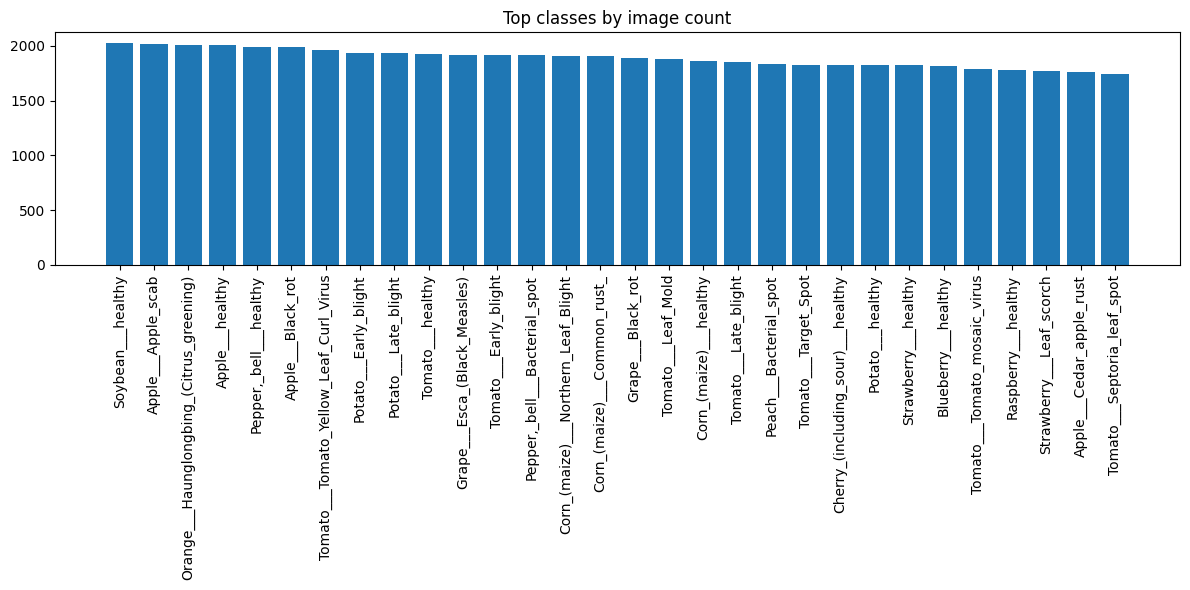

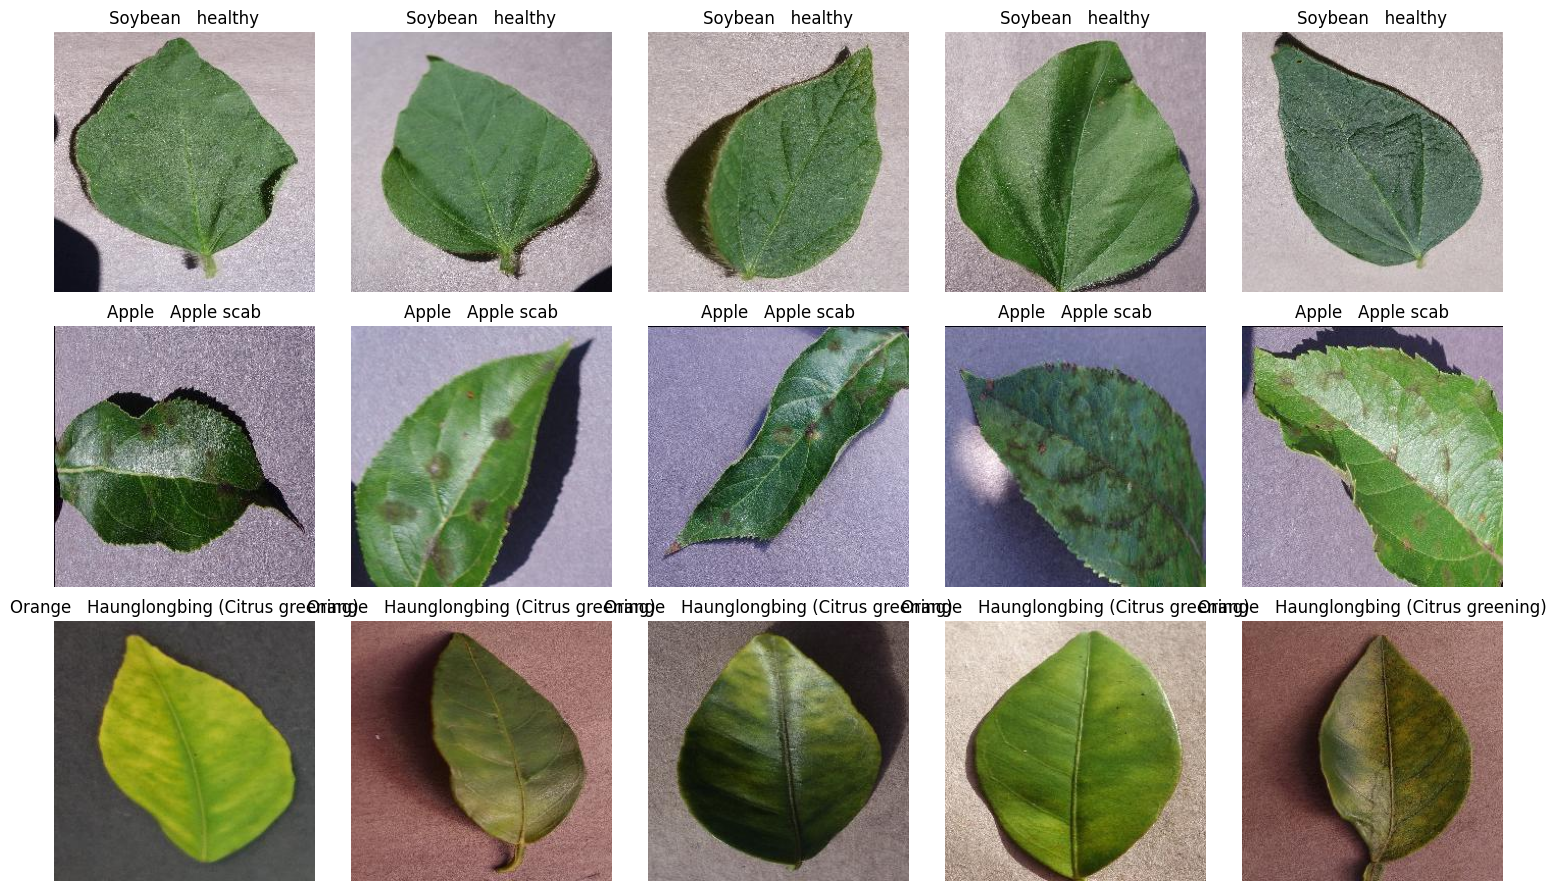

In [4]:
plt.figure(figsize=(12,6))
vals = list(class_counts.values())
keys = list(class_counts.keys())
plt.bar(range(min(30, len(vals))), vals[:30])
plt.xticks(range(min(30, len(vals))), keys[:30], rotation=90)
plt.title('Top classes by image count')
plt.tight_layout()
plt.show()


# show random samples from some classes
NUM_COLS = 5
NUM_ROWS = 3
plt.figure(figsize=(NUM_COLS*3, NUM_ROWS*3))
for i, cls in enumerate(list(class_counts.keys())[:NUM_ROWS]):
    cls_dir = Path(DATA_DIR)/cls
    imgs = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png'))
    for j in range(NUM_COLS):
        idx = i*NUM_COLS + j + 1
        plt.subplot(NUM_ROWS, NUM_COLS, idx)
        if imgs:
            img_p = random.choice(imgs)
            img = Image.open(img_p).convert('RGB')
            plt.imshow(img)
            plt.title(cls.replace('_', ' '))
            plt.axis('off')
plt.tight_layout()
plt.show()

# **Image Size Distribution and Corrupted Checks**

In [5]:
widths = []
heights = []
corrupted = []

print("Checking image dimensions...")

for i, f in enumerate(files):
    try:
        with Image.open(f) as im:
            w, h = im.size
            widths.append(w)
            heights.append(h)
    except Exception:
        corrupted.append(f)

print("Done!")
print("Corrupted images:", len(corrupted))



Checking image dimensions...
Done!
Corrupted images: 0


# **Splitting Train and Test Set**

In [6]:
train_files, test_files, train_labels, test_labels = train_test_split(
    files, labels, test_size=0.2, stratify=labels, random_state=SEED)

val_files, test_files, val_labels, test_labels = train_test_split(
test_files, test_labels, test_size=0.5, stratify=test_labels, random_state=SEED)


print('Split sizes ->', 'train:', len(train_files), 'val:', len(val_files), 'test:', len(test_files))

Split sizes -> train: 56236 val: 7029 test: 7030


# **Dataset Class**

In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),            # Resize to fixed size
    transforms.RandomHorizontalFlip(p=0.5),   # Flip horizontally
    transforms.RandomRotation(20),            # Rotate within 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Random color changes
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))      # Normalize
])

# Validation transforms (no augmentation here)
valid_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Apply to datasets
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(root=valid_dir, transform=valid_transforms)

In [8]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training images: {len(train_data)}")
print(f"Number of validation images: {len(valid_data)}")
print(f"Classes: {train_data.classes}")

Number of training images: 70295
Number of validation images: 17572
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_lea

# **Model Building: Simple CNN Model**

In [29]:
class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 256)  # assuming input (128x128)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
# Initialize model
num_classes = len(train_data.classes)  
model = PlantDiseaseCNN(num_classes).to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [47]:
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Linear-5                  [-1, 256]      16,777,472
           Dropout-6                  [-1, 256]               0
            Linear-7                   [-1, 38]           9,766
Total params: 16,806,630
Trainable params: 16,806,630
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 7.50
Params size (MB): 64.11
Estimated Total Size (MB): 71.80
----------------------------------------------------------------


## Training

In [31]:
epochs = 50
patience = 7  
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
early_stop_counter = 0


train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} ========  Training Started ----")
    # ------- Training -------
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    batch_counter = 0
    print(len(train_loader) )
    
    for images, labels in train_loader:
        batch_counter += 1 
        images, labels = images.to(device), labels.to(device)

        print(f"\rEpoch {epoch+1} --- Image {batch_counter} Loaded", end="", flush=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        print(f"\r{batch_counter} pass done!", end="", flush=True)

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # ------- Validation -------
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss = val_running_loss / len(valid_loader)

    #  history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # ------- Model Checkpoint -------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_model.pth")
        print("  Best model updated and saved!")
        early_stop_counter = 0  # reset early stopping
    else:
        early_stop_counter += 1

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # ------- Early Stopping -------
    if early_stop_counter >= patience:
        print(f"⏹ Early stopping at epoch {epoch+1}")
        break

# Load best weights
model.load_state_dict(best_model_wts)
print(f" Training Finished. Best Val Acc: {best_val_acc:.2f}%")

Epoch 1 ========  Training Started ----
1099
1099 pass done!ge 1099 Loaded  Best model updated and saved!
Epoch [1/50] Train Loss: 1.8664 | Val Loss: 0.9817 | Train Acc: 45.02% | Val Acc: 70.75%
Epoch 2 ========  Training Started ----
1099
1099 pass done!ge 1099 Loaded  Best model updated and saved!
Epoch [2/50] Train Loss: 1.2059 | Val Loss: 0.7287 | Train Acc: 62.98% | Val Acc: 79.51%
Epoch 3 ========  Training Started ----
1099
1099 pass done!ge 1099 Loaded  Best model updated and saved!
Epoch [3/50] Train Loss: 1.0349 | Val Loss: 0.5647 | Train Acc: 68.03% | Val Acc: 83.63%
Epoch 4 ========  Training Started ----
1099
1099 pass done!ge 1099 LoadedEpoch [4/50] Train Loss: 0.8888 | Val Loss: 0.5765 | Train Acc: 72.68% | Val Acc: 82.12%
Epoch 5 ========  Training Started ----
1099
1099 pass done!ge 1099 Loaded  Best model updated and saved!
Epoch [5/50] Train Loss: 0.7924 | Val Loss: 0.4110 | Train Acc: 75.33% | Val Acc: 87.37%
Epoch 6 ========  Training Started ----
1099
1099 pass do

### Saving the model using torchscript

In [ ]:
scripted_model = torch.jit.script(model)
scripted_model.save("plant_disease_simple_cnn_torchscript.pt")

In [12]:
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)  # normalize
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

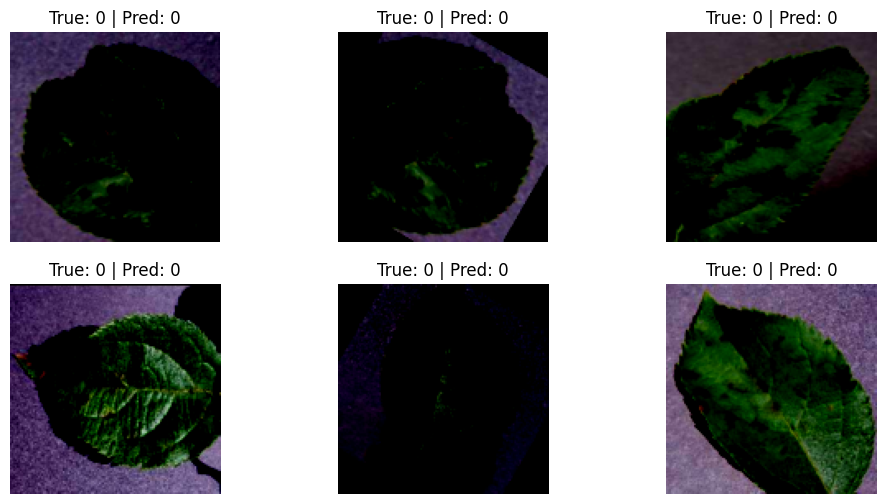

In [ ]:
# Get a batch from validation loader
dataiter = iter(valid_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Show first 6 images
plt.figure(figsize=(12, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    title = f"True: {labels[i+7].item()} | Pred: {preds[i].item()}"
    imshow(images[i+7].cpu(), title)

plt.show()

## Confusion Matrix

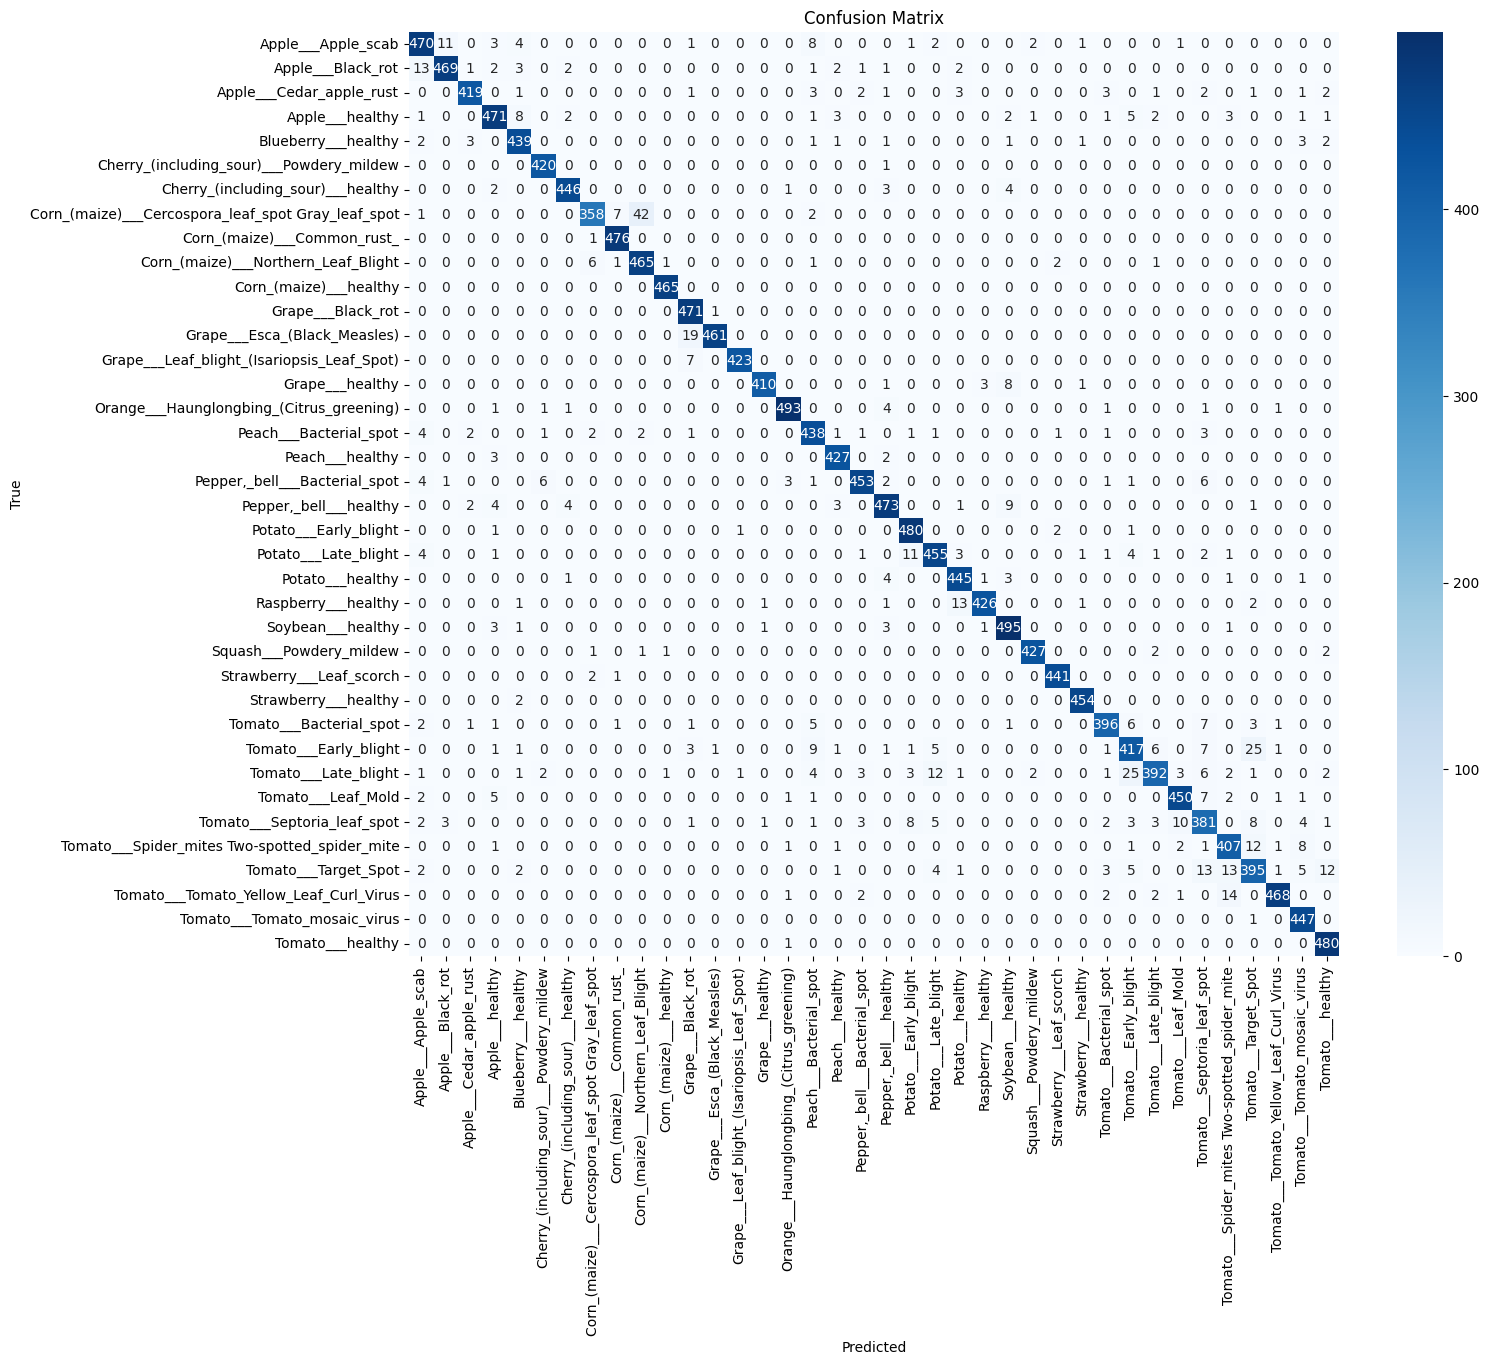

In [45]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
classes = valid_loader.dataset.classes  

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Load Saved Model

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.jit.load("plant_disease_simple_cnn_torchscript.pt", map_location=device)
model.eval()

print("TorchScript model loaded successfully and set to evaluation mode.")

TorchScript model loaded successfully and set to evaluation mode.


# **Model Building: Transfer Learning using ResNet18**

In [9]:
resNetmodel = models.resnet18(pretrained=True)

# Freeze all convolutional base parameters
for param in resNetmodel.parameters():
    param.requires_grad = False

# Replace the classifier head for plant disease dataset
resNetmodel.fc = nn.Sequential(
    nn.Linear(resNetmodel.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, NUM_CLASSES)
)

resNetmodel = resNetmodel.to(device)
print(resNetmodel)

d:\SOUMYADEEP_24MDT0082\Plant Desease detection\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\SOUMYADEEP_24MDT0082\Plant Desease detection\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
resNetoptimizer = optim.Adam(resNetmodel.fc.parameters(), lr=LR)

# Training

In [11]:
num_epochs = 50

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1} ========  Training Started ----")
    # --- Training ---
    resNetmodel.train()
    running_loss, correct, total = 0.0, 0, 0
    batch_counter = 0
    for images, labels in train_loader:
        batch_counter += 1
        images, labels = images.to(device), labels.to(device)

        print(f"\r  Epoch {epoch+1} ---  Image {batch_counter} Loaded", end="", flush=True)
        resNetoptimizer.zero_grad()
        outputs = resNetmodel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        resNetoptimizer.step()
        print(f"\r{batch_counter} pass done!", end="", flush=True)

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = 100 * correct / total

    print("")
    # --- Validation ---
    resNetmodel.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        img_cnt = 0
        for images, labels in valid_loader:
            img_cnt += 1
            print(f'\r Validation image {img_cnt} loaded ----', end="", flush=True)
            images, labels = images.to(device), labels.to(device)
            outputs = resNetmodel(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print("")
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Acc: {val_acc:.2f}%")

#save trained model
torch.save(resNetmodel.state_dict(), "resnet18_finetuned_plant_disease.pth")
print("Model saved as resnet18_finetuned_plant_disease.pth")





Epoch 1 ========  Training Started ----
1099 pass done!Image 1099 Loaded
 Validation image 275 loaded ----
Epoch [1/50] | Train Loss: 1.9832 | Train Acc: 50.71% | Val Acc: 75.71%

Epoch 2 ========  Training Started ----
1099 pass done!Image 1099 Loaded
 Validation image 275 loaded ----
Epoch [2/50] | Train Loss: 0.9894 | Train Acc: 72.31% | Val Acc: 80.45%

Epoch 3 ========  Training Started ----
1099 pass done!Image 1099 Loaded
 Validation image 275 loaded ----
Epoch [3/50] | Train Loss: 0.7938 | Train Acc: 76.76% | Val Acc: 82.37%

Epoch 4 ========  Training Started ----
1099 pass done!Image 1099 Loaded
 Validation image 275 loaded ----
Epoch [4/50] | Train Loss: 0.7072 | Train Acc: 78.82% | Val Acc: 83.95%

Epoch 5 ========  Training Started ----
1099 pass done!Image 1099 Loaded
 Validation image 275 loaded ----
Epoch [5/50] | Train Loss: 0.6438 | Train Acc: 80.38% | Val Acc: 84.55%

Epoch 6 ========  Training Started ----
1099 pass done!Image 1099 Loaded
 Validation image 275 load

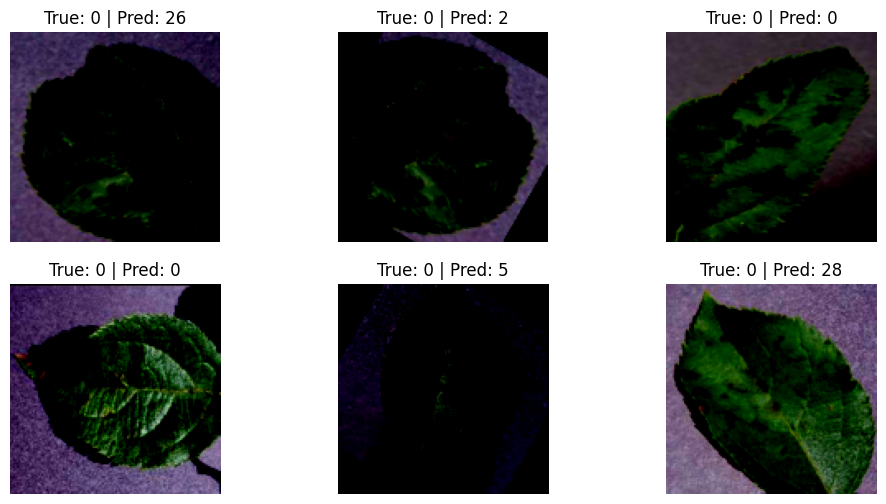

In [13]:
# Get a batch from validation loader
dataiter = iter(valid_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Predictions
resNetmodel.eval()
with torch.no_grad():
    outputs = resNetmodel(images)
    _, preds = torch.max(outputs, 1)

# Show first 6 images
plt.figure(figsize=(12, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    title = f"True: {labels[i+7].item()} | Pred: {preds[i].item()}"
    imshow(images[i+7].cpu(), title)

plt.show()